<a href="https://colab.research.google.com/github/y0ngma/python_basic/blob/master/1_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%9D%84%EC%9D%B4%EC%9A%A9%ED%95%9C%EB%B2%88%EC%97%AD%EC%84%9C%EB%B9%84%EC%8A%A4%EC%9D%98%EC%96%B8%EC%96%B4%EA%B0%90%EC%A7%80%EC%84%9C%EB%B9%84%EC%8A%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **머신 러닝을 이용한 번역서비스의 언어 감지**


---

- 1~6단계 까지 한번 쭉 (삼천포 빠지지 않고 가보라)

# 1.연구목표 설정

- 유사서비스 : 카카오번역, 파파고, 구글번역...
- 언어 감지하는 방법은 지도학습법을 사용하겠다.
  - 알파뱃(26 features)의 빈도 -> en, fr, id, t...
  - 독립변수의 빈도를 보고 레이블(정답, 종속변수)를 판단하게 되는 형태 -> 분류(지도학습)
  - 비영어권 제외, 알파벳 사용국가 분류. 총 데이터도 제공된 자료만으로 사용(4개 국가)
  - 알고리즘의 업데이트 시점은 로그를 축척하여 1만건(실험치) 누적되면 추가 학습 후 갱신하는 방식으로 진행

- **전체 흐름**

step|단계명|수행내용
:--:|--:|:--
1|연구목표 설정|- 언어를 감지하는 웹서비스이다<br><br>- 머신러닝의 지도학습법의 분유 알고리즘을 이용하여 분류기를 구현하겠다<br><br>- 최적화 부분은 생략<br><br>- 정확도에 대한 정량적인 목표는 생략
2|데이터수집/확보|- 실전 : 위키에서 텍스트를 웹스크래핑으로 수집하여 데이터확보<br><br>- 프로토타입구현 : 제공데이터를 사용하겠다
3|데이터준비|- 전처리(데이터 원재료에서 알파벳을 빼고 모두 제거->정규식)<br><br>- 빈도계산, 정규화<br><br>- 훈련용데이터와 학습용데이터를 75:25로 나눈다(모델링구축단계에서도)
4|데이터분석|- 영어권 언어별 알파벳 출현(사용) 빈도가 다르다는 명제(논문, 주장)을 근거를 증명<br><br>- 탐색적분석, EDA를 이용하여 표현(bar, line chart)
5|데이터모델링구축|- 알고리즘 선택<br><br>- 훈련용데이터와 학습용데이터를 75:25로 나눈다(데이터준비단계에서도)<br><br>- 학습<br><br>- 예측<br><br>- 성능평가(피드백 후 튜닝단계 진입가능. 이번에는 생략)<br><br>- 모델 덤프
6|시스템통합|- 웹서비스 구축<br><br>- 모델 덤프로드 모듈 구현<br><br>- 언어감지를 처리하는 모듈 구현<br><br>- 번역 요청 로그처리

   - 애자일 2, 3, 4 ?



- 프로젝트의 주제
- 6단계 시스템 통합을 대비해서 1단계를 설정한다
- 목표, 결론이 명확해야 한다
  - 넷플릭스 -> 추천 시스템의 정확도를 기존대비 3% 증가 시켜라
  - 사용자가 텍스트를 넣으면 해당 텍스트의 언어를 감지해 내라
  - 신규 서비스 인가?
  - 사내 프로그램용, 그룹웨어의 어떤 메뉴인가?
  - 의사결정을 위한 레포트인가?
- 주제가 새로운 주장에 근거한거라면 -> 관련 논문을 체크
  - 내 주장의 근거를 댄다.

- **데이터 분석의 목적 : 데이터에 대한 통찰을 얻는다**

# 2.데이터 수집/확보 


- 실전 : 위키에서 텍스트를 웹스크래핑으로 수집하여 데이터확보
- 프로토타입구현 : 제공데이터를 사용하겠다

- 데이터 수집/확보 전략
  1. 제공받는다 : 공공데이터, 대학/연구기관 데이터, 챌린지 데이터(kaggle deepfake), 민원제공 후 받기
    - 정형적 데이터 유형으로 제공된다(이미 구조가 갖춰져 있다)
  - 공개는 되어 있는데(웹) 직접 해결 부분
    - 반정형, 비정형적으로 데이터가 제공된다.
    - 방법
      1. open API 이용 수집 : naver, kakao, google -> 쿼터제한(많은계정,키필요)
      1. web Scraping을 이용하여 수집 : requests, BS4
      1. Crawling 으로 수집 : selenium + Web driver
          - 한단계씩 하기 위해 쥬피터에서 가동
      
      

      


In [0]:
# 위키피디아는 사이트를 들여다 보니 스크래핑 수준이면 처리가 가능하다.

'''
https://ko.wikipedia.org/wiki/방탄소년단
https://en.wikipedia.org/wiki/BTS_(band)
https://fr.wikipedia.org/wiki/BTS_(groupe)

위키피디아에서 최초 url의 국가코드를 조정하면 국가별로 진입가능
단, 검색어가 영어권에서 범용적인 부분을 사용하거나
아니면, 국가별로 리스트업이 필요하다
'''

In [0]:
# URL에 대한 고민은 일단 전제하고, 하나의 사이트에서 처리 루틴을 정리
# 미국 위키를 전제로 처리
target_url = 'https://en.wikipedia.org/wiki/BTS_(band)'
target_url

'https://en.wikipedia.org/wiki/BTS_(band)'

In [0]:
# 웹 스크래핑 관련 모듈 가져오기
# 요청 - 응답 (request)
# 통신담당 : request
# 파싱담당 : BS4
## parser 4개중 다음의 선정이유
  # html5lib 속도가 가장느림, 정확한 처리 중요

import urllib.request as req
from bs4 import BeautifulSoup

In [0]:
# 요청
res = req.urlopen(target_url)
# 파싱
soup = BeautifulSoup( res, 'html5lib')

type(soup)
# DOM Tree 생성
# soup


bs4.BeautifulSoup

In [0]:
# 대상 태그들을 모은다
ps = soup.select('#mw-content-text p') # ps는 p들을 담은 변수라고 선언
len(ps), type(ps)


(79, list)

In [0]:
# ps에서 한개 뽑아서 텍스트를 출력해보았다.
# 텍스트를 모은다, 여러개를 리스트에 리스트내포를 이용하여 
# 79개의 p태그에서 텍스트를 추출하여 리스트에 추가하시오
tmp = list()
for p in ps:
  # print('[%s]' % p.text)
  tmp.append('[%s]' % p.text.strip()) # 알파뱃 양옆 처리는 함수단계에서 가능
  # 나머지는 정규식으로
  # break
tmp[:3], tmp[-3:]


(['[]',
  '[]',
  '[BTS (Korean:\xa0방탄소년단; RR:\xa0Bangtan Sonyeondan), also known as the Bangtan Boys, is a seven-member South Korean boy band that began its formation in Seoul in 2010.[3] The septet co-writes and produces much of their output. Originally a hip hop group, their musical style has evolved to include a wide range of genres. Their lyrics, often focused on personal and social commentary, touch on the themes of mental health, troubles of school-age youth, loss, the journey towards loving oneself, and individualism. Their work features references to literature and psychological concepts and includes an alternative universe storyline. The group have staged several world tours.]'],
 ['[]', '[Japanese-language studio albums]', '[]'])

In [0]:
# for p in ps:
#   tmp[p.text.strip()]
tmp = [p.text.strip() for p in ps]
tmp[:4]

['',
 '',
 'BTS (Korean:\xa0방탄소년단; RR:\xa0Bangtan Sonyeondan), also known as the Bangtan Boys, is a seven-member South Korean boy band that began its formation in Seoul in 2010.[3] The septet co-writes and produces much of their output. Originally a hip hop group, their musical style has evolved to include a wide range of genres. Their lyrics, often focused on personal and social commentary, touch on the themes of mental health, troubles of school-age youth, loss, the journey towards loving oneself, and individualism. Their work features references to literature and psychological concepts and includes an alternative universe storyline. The group have staged several world tours.',
 'The group initially formed as teenagers under Big Hit Entertainment and released their debut single album, 2 Cool 4 Skool (2013). Subsequent work such as their first U.S. Billboard 200 entries The Most Beautiful Moment in Life, Part 2 (2015), The Most Beautiful Moment in Life: Young Forever (2016), and Wings

In [0]:
# 리스트에 존재하는 문자열들을 한개의 문자열로 통합
src_txt = ' '.join(tmp)
len(src_txt), src_txt[:100]

(71210,
 '  BTS (Korean:\xa0방탄소년단; RR:\xa0Bangtan Sonyeondan), also known as the Bangtan Boys, is a seven-member Sou')

- 영어는 소문자로 통일(lower)
- 영어를 제외하고는 모두 제거(정규식)
- 띄어쓰기 정도는 남기자(가독성확보, 정규식 중 공백은 남김)

In [0]:
# 정규식
import re
# 알파뱃만 날려라
# p = re.compile('[a-zA-Z]*')
# 알파뱃만 남겨라 ^
p = re.compile('[^a-zA-Z]*')
tmp = p.sub('', src_txt)[:100]
# tmp[:50]
tmp.lower()[:50]

'btskoreanrrbangtansonyeondanalsoknownasthebangtanb'

In [0]:
# 정규식을 컴파일 하고,
# 이를 이용하여 데이터를 처리한다
# \s : Whitespace(공백, 탭...)
# \w : Word 단어하나(+ 또는 *를 통해 늘릴 수 있다)
#류현진 쓰고 한칸 띄고 단어 한덩어리까지로 시작하는 문자열
p1 = re.compile('')
# tmp1 = p1.sub('', src_txt)
# tmp1[:100]

# p.findall(src_txt)

['  ',
 '',
 '',
 '',
 ' (',
 '',
 '',
 '',
 '',
 '',
 '',
 ':\xa0방탄소년단; ',
 '',
 '',
 ':\xa0',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '), ',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 ', ',
 '',
 '',
 ' ',
 '',
 ' ',
 '',
 '',
 '',
 '',
 '',
 '-',
 '',
 '',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 ' 2010.[3] ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '-',
 '',
 '',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 '',
 '',
 ' ',
 '',
 '',
 ' ',
 '',
 '',
 '',
 

In [0]:
# 제공받은것

# 파일을 한번에 다 읽으려면특정폴더 밑에서 특정 패턴을 가진 파일들을 지정해서 목록화
# 파일명 : 언어코드-넘버.txt
# /content/train/en-1.txt

# 파일 리스트 획득


In [0]:
# 파일 리스트 획득
import glob

file_list = glob.glob('/content/drive/My Drive/data/02CntWord/train/*.txt') # .txt 인 모든 파일

type(file_list), file_list[:2]

(list,
 ['/content/drive/My Drive/data/02CntWord/train/fr-8.txt',
  '/content/drive/My Drive/data/02CntWord/train/id-12.txt'])

In [0]:
file_list.sort()
file_list

['/content/drive/My Drive/data/02CntWord/train/en-1.txt',
 '/content/drive/My Drive/data/02CntWord/train/en-2.txt',
 '/content/drive/My Drive/data/02CntWord/train/en-3.txt',
 '/content/drive/My Drive/data/02CntWord/train/en-4.txt',
 '/content/drive/My Drive/data/02CntWord/train/en-5.txt',
 '/content/drive/My Drive/data/02CntWord/train/fr-10.txt',
 '/content/drive/My Drive/data/02CntWord/train/fr-6.txt',
 '/content/drive/My Drive/data/02CntWord/train/fr-7.txt',
 '/content/drive/My Drive/data/02CntWord/train/fr-8.txt',
 '/content/drive/My Drive/data/02CntWord/train/fr-9.txt',
 '/content/drive/My Drive/data/02CntWord/train/id-11.txt',
 '/content/drive/My Drive/data/02CntWord/train/id-12.txt',
 '/content/drive/My Drive/data/02CntWord/train/id-13.txt',
 '/content/drive/My Drive/data/02CntWord/train/id-14.txt',
 '/content/drive/My Drive/data/02CntWord/train/id-15.txt',
 '/content/drive/My Drive/data/02CntWord/train/tl-16.txt',
 '/content/drive/My Drive/data/02CntWord/train/tl-17.txt',
 '/con

# 3.데이터 준비

- 전처리, 정제, 적제, 등등 
- 데이터의 품질을 향상시킨다
- 데이터 성분 종류
  - 수치
    - 정수
      - 0 이나 1
        - 이진 데이터, 바이너리, 원-핫인코딩방식
      - ... -1, 0, 1, ...
        - 정규화 처리가 진행되서 0~1 사이로 값을 몰아 넣는다.
    - 부동소수
      - ...-1.1xxx , 0, 1.1xxx, ...
        - 정규화 처리가 진행되서 0~1 사이로 값을 몰아 넣는다.
  - 문자열(텍스트)
    1. 문자열
    1. 형태소분석기(konlpy > Mecab)
    1. 분절 > 형태소가 나온다
    1. 사전을 생성
    1. 형태소를 인덱스로 치환
    1. 0, 1 로 인코딩(원-핫 인코딩)
    1. 범주형
- 모든 데이터는 결론적으로 **수치화** 시켜야 한다. 머신러닝/딥러닝을 위해서




## 언어별 알파뱃 빈도수 그래프


### 1.데이터 준비

  - 데이터를 읽으면서 알파벳의 빈도를 계산
  - 언어코드도 획득해서, 해당 언어에 알파뱃의 빈도는 이런 식으로 표현
  - 알파벳별 빈도는 (feature), 언어코드는( label)
  - train 데이터 row가 20개( 국가별 5개), column(26개 알파뱃 + 1개 답)
  - shape -> (20, 27)
  - 위 과정을 함수화 시켜서 편리하게 작업 !!


In [0]:
# 텍스트 파일이 하나 확인되면 -> file_list의 개수만큼 반복(20번)
  # 언어코드 획득
    # 파일에서 파일명획득 - > 언어코드가 존재
    # 언어코드를 추출
  # 알파뱃별 빈도수 획득
    # 전처리를 통해서 영어만 둔다
    # 알파벳별 빈도를 계산한다.


### 2.언어코드 획득

In [0]:
# 파일에서 파일명획득
file_list[0].split('/')[-1][:2]
# 언어코드 'en' 추출


'en'

In [0]:
# 외장함수를 활욜해서 처리
import os
# 파일명획득
# file_list[0].split('/')[-1]과 결과는 동일
name = os.path.basename(file_list[0])
name


'en-1.txt'

In [0]:
# 정규식으로 언어코드 획득
import re
p         = re.compile('^[a-z]{2}')
# lang_code = p.match('en-1.txt').group()
lang_code = p.match(name).group()
lang_code

'en'

###  3.알파벳 빈도 계산

In [0]:
# 텍스트 파일을 읽어서 -> 알파뱃만 남긴다.
# 최종 변수명 text

# 텍스트 파일을 열고(I/O)
with open(file_list[0]) as f:
  # 절차적으로 파일 크기 먼저확인후 너무 안크면 읽어서
  text = f.read().lower()
  # 알파뱃만 남기고 (알파뱃, 띄어쓰기까지 남기고))
  p = re.compile('[^a-z]*')
  text = p.sub('', text) # 일치되는 표현만 (치환)제거 시킨다
  print(text[:100])
  pass
  # 알파뱃만 남긴다.

themainhenryfordmuseumbuildinghousessomeoftheclassroomsforthehenryfordacademyhenryfordacademyisthefi


In [0]:
# 알파뱃별로 카운트를 담을 그릇(한개의 이름으로 26개의 정보를 담는그릇)
# 파이썬의 리스트를 사용한다. 수정가능
# 갯수를 표현하는 변수를 만든다
counts = [0 for n in range(26)] # [0]*26
counts


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [0]:
# text 에서 한글자씩 읽어서 a면 counts[0] += 1 ->counts[a-a]+=1
# z -> counts[25] +=1
# t -> counts[?] +=1
# ord()특정 문자의 아스키코드값을 리턴
# a-z까지는 연속적으로 아스키값이 배치되어 잇다
# 따라서 특정문자의 위치는 ord('소문자') - ord('a')
ord('a'), ord('z'), (ord('z')-ord('a'))

(97, 122, 25)

In [0]:
list1 = ['a', 'b', 'c']
tmp=[]
for i in list1:
  tmp.append(ord(i)-ord('a'))
tmp

[0, 1, 2]

In [0]:
ASCII_A = ord('a')
for ch in text:
  # print(ch)
  # 한개 뽑힌 문자의 아스키값 ord(ch)
  counts[(ord(ch)-ASCII_A)] +=1
print(counts)
print(len(counts))

[349, 59, 210, 212, 484, 72, 88, 201, 340, 8, 25, 247, 121, 356, 412, 76, 0, 357, 282, 370, 119, 45, 65, 3, 92, 2]
26


- 데이터를 들여다 보니, 값의 편차가 크다(최대, 최소 등으로 확인)
- 데이터는 빈도를 표현함으로, 최대최소의 의미보다는, 총 빈도에서 특정 알파뱃이
- 얼마나 등장했는가가 중요하다 -> 이것을 기준으로 정규화 처리 standard scaler
- 데이터 준비단계에서는 데이터의 품질을 향상을 목표로 하고 주 수다능로 정한다.

In [0]:
sum(counts), len(text) # 총 빈도수라는 값으로 두 결과는 상동.

(4595, 4595)

In [0]:
# list(map(함수 , 데이터덩어리))
# 함수는 map이 자동으로 맴버수 만큼 호출한다
# x:맴버 한개 한개, ...
def checkNorm(x): # normalize 
  return x / len(text) # 알파뱃빈도/총빈도
frequences = list(map(checkNorm, counts))
print(sum(frequences), frequences)

1.0 [0.07595212187159957, 0.012840043525571273, 0.04570184983677911, 0.04613710554951034, 0.10533188248095757, 0.015669205658324265, 0.019151251360174103, 0.043743199129488576, 0.07399347116430903, 0.0017410228509249185, 0.00544069640914037, 0.05375408052230685, 0.026332970620239392, 0.07747551686615888, 0.08966267682263329, 0.016539717083786723, 0.0, 0.07769314472252448, 0.061371055495103376, 0.08052230685527748, 0.02589771490750816, 0.009793253536452665, 0.014145810663764961, 0.0006528835690968443, 0.02002176278563656, 0.0004352557127312296]


In [0]:
# 이번처럼 lambda 함수를 쓰면 좋은 상황에서는 이용하도록 하라
frequences = list(map( lambda x : x/len(text), counts))
print(sum(frequences), frequences)

1.0 [0.07595212187159957, 0.012840043525571273, 0.04570184983677911, 0.04613710554951034, 0.10533188248095757, 0.015669205658324265, 0.019151251360174103, 0.043743199129488576, 0.07399347116430903, 0.0017410228509249185, 0.00544069640914037, 0.05375408052230685, 0.026332970620239392, 0.07747551686615888, 0.08966267682263329, 0.016539717083786723, 0.0, 0.07769314472252448, 0.061371055495103376, 0.08052230685527748, 0.02589771490750816, 0.009793253536452665, 0.014145810663764961, 0.0006528835690968443, 0.02002176278563656, 0.0004352557127312296]


In [0]:
# 텍스트 파일 1개에 대한 최종 결과물
print( lang_code, frequences )

en [0.07595212187159957, 0.012840043525571273, 0.04570184983677911, 0.04613710554951034, 0.10533188248095757, 0.015669205658324265, 0.019151251360174103, 0.043743199129488576, 0.07399347116430903, 0.0017410228509249185, 0.00544069640914037, 0.05375408052230685, 0.026332970620239392, 0.07747551686615888, 0.08966267682263329, 0.016539717083786723, 0.0, 0.07769314472252448, 0.061371055495103376, 0.08052230685527748, 0.02589771490750816, 0.009793253536452665, 0.014145810663764961, 0.0006528835690968443, 0.02002176278563656, 0.0004352557127312296]


### 4.함수화하기
- 위의 구성 내용을 한칸에 넣어서 함수화 시킨다.

In [0]:
import re, os
def parsingLangFreq(file_path):
  # 언어 코드 획득
  name = os.path.basename(file_path)
  p         = re.compile('^[a-z]{2}')
  lang_code = p.match(name).group()

  # 단어의 빈도
  with open(file_path) as f:
    text = f.read().lower()
    p = re.compile('[^a-z]*')
    text = p.sub('', text)

  counts = [0]*26
  ASCII_A = ord('a')
  for ch in text:
    counts[(ord(ch)-ASCII_A)] +=1

  frequences = list(map( lambda x : x/len(text), counts))

  return (lang_code, frequences)

  

In [0]:
print(parsingLangFreq(file_list[0]))

('en', [0.07595212187159957, 0.012840043525571273, 0.04570184983677911, 0.04613710554951034, 0.10533188248095757, 0.015669205658324265, 0.019151251360174103, 0.043743199129488576, 0.07399347116430903, 0.0017410228509249185, 0.00544069640914037, 0.05375408052230685, 0.026332970620239392, 0.07747551686615888, 0.08966267682263329, 0.016539717083786723, 0.0, 0.07769314472252448, 0.061371055495103376, 0.08052230685527748, 0.02589771490750816, 0.009793253536452665, 0.014145810663764961, 0.0006528835690968443, 0.02002176278563656, 0.0004352557127312296])


In [0]:
# 훈련용 데이터, 테스트용 데이터 로드
# 중간 경로가 train or test
def load_data( path='train'):
  file_lists = glob.glob( '/content/drive/My Drive/data/02CntWord/{}/*.txt'.format(path) )
  # 정답 담을 리스트 필요
  labels = list()
  freqs = list()
  # 파일 경로를 하나씩 뽑아서 
  for f in file_lists:
    # 파일 1개당, 정답, 빈도수리스트 리턴
    lang, freq = parsingLangFreq( f )
    labels.append( lang )
    freqs.append(freq)
  return { 'labels': labels, 'freqs':freqs }
  
train_data = load_data()
test_data = load_data('test')

In [0]:
pwd

'/content'

In [0]:
# dumps 덤프 (현단계 결과물을 저장)
import json

with open('/content/drive/My Drive/data/02CntWord/labels_freqs_data.json', 'w') as f:
  # json 구조로 저장
  json.dump( [train_data, test_data], f )

# 4.데이터 분석

## 분석
- Descriptive Analysis (설명/서술 분석)
- Exploratory Analysis (탐색적 분석)
- Inferential Analysis (추론/통계적 분석)
- Predictive Analysis ( 예측 분석)
- Causal Analysis (인과/통계적 분석)
- Mechanistic Analysis (기계적 분석)


### Descriptive Analysis (설명/서술 분석)

- 기초 분석
- 기본 통계량 분석
- 요약과 집계를 수행, 데이터의 성질, 특성, 유형들을 확인
- 시각화
  - Pie, Bar, Box
- 데이터의 shape, dim, head(), tail(), describ, info()


### Exploratory Analysis (탐색적 분석)

- EDA
- 중간에 재미잇는 요소가 발견되더라도, 원 목적에 부합하게 진행시킨다. (삼천포빠지기 주의)
- 시각화 처리
  - matplotlib, seaborn, folium, 3rd party lib etc

### Inferential Analysis (추론/통계적 분석)

- 모집단-표본(샘플)간의 관계를 탐구하고, 표본을 모집합에 적용시키는 방법에 대해 분석
- 95%의 확률로 모집단의 평균 점수는 XX~ xx 사이 이다. 표준편차 ~, +


### Predictive Analysis ( 예측 분석)

- 머신러닝, 결정트리(알고리즘 등) + 통계적 기법들을 사용한다.
- 미래, 발생하지 않는 사건에 대해 예측을 진행
- 이유보다는 정확한 예측이 더 중요하다.
- 예)  
  다이어트 성공율을 높이기 위한 다양한 변수들이 존재, 이런 변수들간의 관계성보다는 어떤 변수들을 활용해서 성공율을 높일 수 있는지 예측력을 높이는 쪽으로 더 집중되어 있다.  
  - 다이어트를 성공시키기 위해서 xxx를 해야한다.  
    - 솔루션 제공이 더 중요  
    (Prescriptive Analysis)  

### Causal Analysis (인과/통계적 분석)

- 독립-종속 변수간의 인과관계를 밝힌다.
- A/B test
- 회귀 
  - 변수 2개 간의 상관성을 분석
    - 선형 회귀
  - 변수가 여러개의 상관성을 분석
    - 다항회귀 Multi variable
  - 변수가 범주형이면
    - Logistics 회귀 
    

### Mechanistic Analysis (기계적 분석)
- 독립변수가 종속변수에게 어떤 매커니즘으로 영향을 미치는가?
- 독립변수와 종속변수 상의 인과관계 + 어떤 독립변수가 어떤 작용을 하여 영향을 미치는지까지 전개
- 머신러닝
  - 지도 학습 : 답이 존재
    - 분류 : classification
    - 회귀 : regression
  - 비지도 학습 : 답이 없음
    - 군집화 : clustering
    - 전처리기 : preprocessing
  - 준지도 학습
    - 데이터가 일부는 label이 존재하고, 대부분은 label이 없다
  - 강화 학습
    - agent존재, 잘한 행동에게는 reward를 제공, 잘못한 행동에게는 패널티를 제공하여 보상쪽으로 행동을 강화시키는 학습법
    - 알파고를 이긴 알파제로
    - 딥러닝
- 딥러닝
  - 인공 신경망을 통하여 학습을 진행하고, 이에 따른 분류, 행동을 취하거나, 창조하거나 등등 
  - 현재로써는 AI를 설명할 때 가장 적합
  - 범위 : AI > ML > DL

## 변수
- 독립변수, 상호간 영향을 미치지 않는다. feature(특성)
- 종속변수, 독립변수에 의해서 결정, label, 정답, class

## 언어별 알파뱃 빈도수 그래프

In [0]:
## 시각적으로 표현
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [0]:
# 데이터 로드
# /content/labels_freqs_data.json
with open('/content/drive/My Drive/data/02CntWord/labels_freqs_data.json', 'r') as f:
  tmp = json.load( f )
len(tmp)
# 0:train, 1:test

2

In [0]:
# 데이터크기 확인
# 훈련
len( tmp[0]['labels'] ), len( tmp[0]['freqs'] )

(20, 20)

In [0]:
## 테스트
len( tmp[1]['labels'] ), len( tmp[1]['freqs'] )

(8, 8)

In [0]:
# 휸련 데이터를 DataFrame으로 빈도데이터만 로드
df_freqs = pd.DataFrame( tmp[0]['freqs'] )
df_freqs.head(2)
# 인덱스나 컬럼 없이 벨류만으로 데이터 프레임 만들기 가능

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,0.072599,0.015761,0.039836,0.051129,0.157111,0.013031,0.013527,0.014396,0.085629,0.004344,0.001862,0.062050,0.029039,0.073964,0.056217,0.023455,0.005833,0.082030,0.066518,0.061057,0.042690,0.015140,0.000745,0.005088,0.004964,0.001986
1,0.147555,0.024698,0.009199,0.039441,0.093372,0.011089,0.033896,0.018523,0.100302,0.005292,0.037928,0.037172,0.038432,0.084677,0.035534,0.034778,0.000000,0.046623,0.081401,0.050781,0.040575,0.008065,0.005040,0.001386,0.013609,0.000630


In [0]:
df_freqs.shape

(20, 26)

In [0]:
# 휸련 데이터를 DataFrame으로 정답 데이터만 로드
df_labels = pd.DataFrame( tmp[0]['labels'] )
df_labels.head(2)
# 인덱스나 컬럼 없이 벨류만으로 데이터 프레임 만들기 가능

,0
0,fr
1,id


In [0]:
df_labels.shape

(20, 1)

In [0]:
# 컬럼명을 명확하기 조정
# df_labels의 컬럼명을 label로 교체
df_labels.columns=['label']
# df_labels.rename(columns={'RangeIndex':'sss'}, inplace=True)
df_labels.info()
df_labels.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
label    20 non-null object
dtypes: object(1)
memory usage: 288.0+ bytes


,label
0,fr
1,id


In [0]:
# df_freqs의 컬럼명을 a-z까지 변경
from string import ascii_lowercase
ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [0]:
df_freqs.columns = list( ascii_lowercase )
df_freqs.head(2)

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,0.072599,0.015761,0.039836,0.051129,0.157111,0.013031,0.013527,0.014396,0.085629,0.004344,0.001862,0.062050,0.029039,0.073964,0.056217,0.023455,0.005833,0.082030,0.066518,0.061057,0.042690,0.015140,0.000745,0.005088,0.004964,0.001986
1,0.147555,0.024698,0.009199,0.039441,0.093372,0.011089,0.033896,0.018523,0.100302,0.005292,0.037928,0.037172,0.038432,0.084677,0.035534,0.034778,0.000000,0.046623,0.081401,0.050781,0.040575,0.008065,0.005040,0.001386,0.013609,0.000630


In [0]:
# df_freqs, df_labels 결합 -> ( 20, 27 )
df_cc = pd.concat([ df_freqs, df_labels ], axis=1)
df_cc.shape

(20, 27)

In [0]:
df_tmp = pd.merge( df_freqs, df_labels, how='outer', left_index=True, right_index=True)
df_tmp.head(2)

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,label
0,0.072599,0.015761,0.039836,0.051129,0.157111,0.013031,0.013527,0.014396,0.085629,0.004344,0.001862,0.062050,0.029039,0.073964,0.056217,0.023455,0.005833,0.082030,0.066518,0.061057,0.042690,0.015140,0.000745,0.005088,0.004964,0.001986,fr
1,0.147555,0.024698,0.009199,0.039441,0.093372,0.011089,0.033896,0.018523,0.100302,0.005292,0.037928,0.037172,0.038432,0.084677,0.035534,0.034778,0.000000,0.046623,0.081401,0.050781,0.040575,0.008065,0.005040,0.001386,0.013609,0.000630,id


### 피벗 ( 특정 컬럼에 반복적으로 데이터가 보이면, 그 종류가 한정적 )

- 현재 데이터를 일종의 로그가 누적 된 데이터이다
- 이 데이터에서 숨겨진 정보를 추출하기 위해서, 관점을 달리하여 데이터를 재구성
- 국가별 알파뱃의 빈도
- row : 국가별 정렬
- column : 알파뱃으로 정렬
- index : en, fr, ... column은 a-z까지 재구성해라 -> pivot_table


In [0]:
# label 값 추출 및 중복제거
df_tmp['label'].unique() # 라벨 중복제거된값 확인 -> 피봇적합성 확인
df_tmp.label.unique()

array(['fr', 'id', 'tl', 'en'], dtype=object)

In [0]:
# 실습 결과물 ( 4, 26 )
df_tmp_pv = pd.pivot_table(df_tmp, index=df_tmp.label)
df_tmp_pv.head(2), df_tmp_pv.shape

(              a         b         c  ...         x         y         z
 label                                ...                              
 en     0.075558  0.018601  0.036565  ...  0.002466  0.016232  0.000788
 fr     0.076183  0.013140  0.036707  ...  0.004234  0.004813  0.000915
 
 [2 rows x 26 columns], (4, 26))

In [0]:
# a~z가  index, 국가가 컬럼
df_tmp_pv.transpose


<bound method DataFrame.transpose of               a         b         c  ...         x         y         z
label                                ...                              
en     0.075558  0.018601  0.036565  ...  0.002466  0.016232  0.000788
fr     0.076183  0.013140  0.036707  ...  0.004234  0.004813  0.000915
id     0.160047  0.026276  0.008391  ...  0.000725  0.012463  0.000807
tl     0.210537  0.021824  0.010842  ...  0.000430  0.025048  0.001396

[4 rows x 26 columns]>

In [0]:
df_tmp_pv = pd.pivot_table(df_tmp, columns = df_tmp.label)
df_tmp_pv.shape

(26, 4)

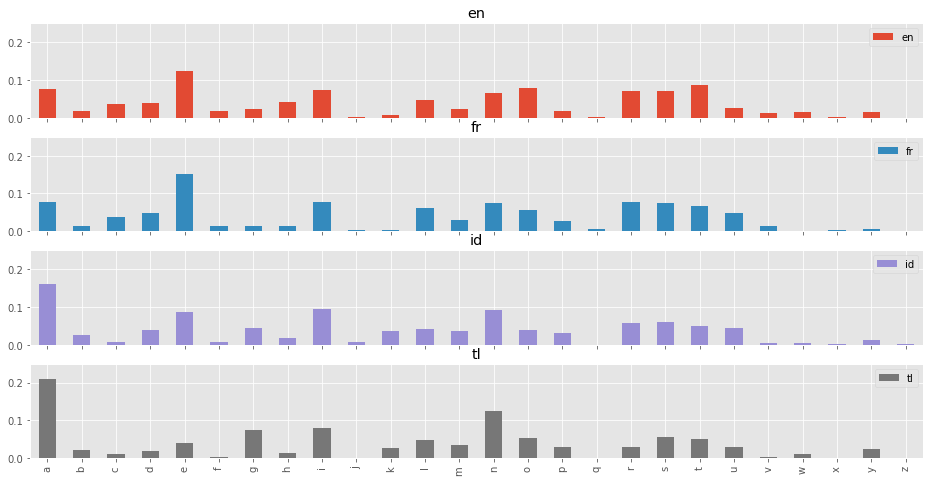

In [0]:
# 바 차트
# ggplot 스타일
plt.style.use('ggplot')
# 플로팅, y축의 값을 특정 구간으로 제한하겠다
df_tmp_pv.plot( kind = 'bar', subplots = True, figsize=( 16, 8 ), ylim=(0, 0.25))
# 저장
plt.savefig('/content/drive/My Drive/data/02CntWord/na_per_freqs.png')
# 보이기
# plt.show()

In [0]:
# 단어별로 (a~z)로 한개의 차트에 국가별로 빈도를 그린다.
# 이 차트는 저장한다.=> a_freqs.png, b_freqs.png, .. z_freqs.png
# 한개의 차트에 여러값을 표현하여 비중의 차이점을 그린다.
# 데이터는 df_tmp 를 이용하여 a만 모아서 국가별로 그리고, b만 모아서..
# 한 차트에 겹쳐그려서 데이터의 위치(분포)가 구분되는지, 겹치는지 확인 -> 히스토그램
# 추가설명
# 차트는 총 26개
# ex) a빈도를 그린다면, 한 차트에 특정국가별로 a만 그린다(국가별로색구분됨)
#     색의 겹침을 보기 위해서 투명값을 부여 alpha=0.4
df_tmp['label'].unique()

array(['fr', 'id', 'tl', 'en'], dtype=object)

In [0]:
# for na in df_tmp['label'].unique():
  # if na == 'en':
df_tmp[df_tmp['label'] == 'en']

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,label
9,0.073806,0.020368,0.031099,0.039641,0.141261,0.020368,0.020368,0.056943,0.065046,0.003285,0.005913,0.039641,0.028909,0.062199,0.066141,0.018835,0.000438,0.072492,0.059571,0.095488,0.024967,0.010731,0.023872,0.003066,0.014893,0.000657,en
10,0.072210,0.027715,0.029977,0.039593,0.121041,0.016780,0.023567,0.059012,0.065234,0.001508,0.013009,0.044872,0.021493,0.058635,0.087670,0.016780,0.000377,0.059201,0.073341,0.093703,0.024321,0.005090,0.019608,0.006033,0.017534,0.001697,en
13,0.084178,0.019912,0.030404,0.038870,0.136998,0.017408,0.031239,0.027423,0.075355,0.002623,0.009777,0.042327,0.024204,0.053535,0.068797,0.020269,0.005485,0.090140,0.071659,0.077739,0.030643,0.013712,0.013950,0.002027,0.010731,0.000596,en
14,0.075952,0.012840,0.045702,0.046137,0.105332,0.015669,0.019151,0.043743,0.073993,0.001741,0.005441,0.053754,0.026333,0.077476,0.089663,0.016540,0.000000,0.077693,0.061371,0.080522,0.025898,0.009793,0.014146,0.000653,0.020022,0.000435,en
15,0.071646,0.012172,0.045643,0.032642,0.120055,0.014661,0.025173,0.023513,0.094606,0.002490,0.001660,0.056985,0.022407,0.075519,0.076625,0.020747,0.001660,0.053942,0.087967,0.081051,0.029046,0.018811,0.011895,0.000553,0.017981,0.000553,en


In [0]:
# df_tmp에서 label이 en 만 모아
# 불리언 인덱싱
df_tmp[df_tmp['label'] == 'en']['a']

9     0.073806
10    0.072210
13    0.084178
14    0.075952
15    0.071646
Name: a, dtype: float64

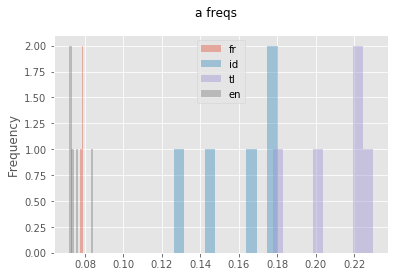

In [0]:
# a-z : 26
for word in ascii_lowercase:
  #print( word )
  # en, fr, id, tl : 4 
  for na in df_tmp['label'].unique():
    # en이면서, a만
    # en만 모아
    tmp = df_tmp[ df_tmp['label'] == na ][word]    
    # tmp.plot(종류, alpha투명값, 라벨)
    tmp.plot( kind='hist', alpha=0.4, label=na )
    # print( word, na )
  # 차트 1개에 대한 추가분
  plt.legend()                   # 범례표기
  plt.suptitle('%s freqs' % word)# 제목
  plt.savefig('/content/drive/My Drive/data/02CntWord/%s_freqs.png' % word) # 저장
  plt.show()
  break # 한개를 돌려보고 제대로 저장까지 되는것 확인후 break 주석처리

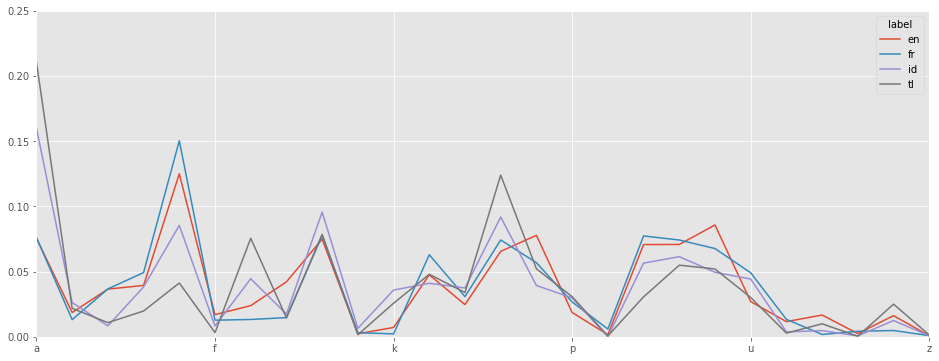

In [0]:
# 선형차트로 최종 다시 확인
df_tmp_pv.plot( kind='line', figsize=(16,6), ylim=(0,0.25) )

# 5.데이터 모델링 구축


- 머신러닝 기준
  - 알고리즘 선택 (선택 시트)
  - 데이터를 학습(훈련)용과 테스트용으로 나눈다
    - 75:25 (황금비율), 통계(80:20)
    - 75(50:25, 학습용:검증용) <- 폴드(fold)
  - 학습 -> fit(), xxxfit()
  - 예측 -> 테스트용 데이터를 이용
  - 성능 평가
    - 분류 : 혼동(오차)행렬 -> 정확도, 정밀도, f1-score, AUR, ROC Curve
      - 회귀 : 평균제곱근오차 -> 손실함수(대표)
    - 최적화
      - 데이터량의 증가(학습량 증가)
      - 알고리즘 교체? 고민( 교차검증)
      - 데이터의 품질?
      - 파이프라인 구축(교차검증)
    - 목표치에 도달할때까지 반복
    - 시스템 통합에 적합한 구조로 덤프

# 6.시스템 통합



- 신규 서비스
  1. 학습한 알고리즘 덤프 파일을 로드
  1. 신규 데이터가 진입
  1. 학습했던 데이터로 변환 처리
  1. 예측, 생성, 등등
  1. 로그 처리
    1. 데이터를 모은다
    1. 알고리즘의 성능을 개선
    1. 온라인학습, 배치학습 등
      - (앞서 만든것을 운영)
- 레포트
  - 보고서(통계쪽에서 많이 사용)
    - 의사 결정에 재료로 제공
- 기성 S/W 에 추가
  - GUI(*.msi, *.dmg, *.pkg, *.exe)
    - QT5, thinker, ...
  - Web(Django, flask)
  - process(os단 백그라운드 처리)
  - mobile
    - android, ios단 에서 ML지원모듈활용, 모델을 제공
    - tensorflowLite

In [0]:
from IPython.display import Image
Image('/content/주석 2020-02-21 131743.png', width=500)
## 최종산출물
## 웹기반(간단한 flask로 정리)
# 머신러닝(Support Vector Machine, Support Vector Classification)으로 언어감지
# 딥러닝(RNN, 다대다 신경망구성)으로는 언어번역


## 구동 원리

1. 사용자가 번역에 필요한 글자를 입력한다(영어 알파뱃)
1. 언어감지라는 버튼을 클릭한다
1. 언어를 읽어서 서버로 전송
1. 서버에서 데이터를 알고리즘이 예측할 수 있는 형태로 변환처리
1. 예측
1. 예측결과를 응답
1. 응답결과를 화면에 표시

 